In [320]:
import pandas as pd
import urllib
import requests
from requests.auth import HTTPBasicAuth
import json
import simplejson as json
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import csv
from bs4 import BeautifulSoup
import time
import numpy as np
import branca.colormap as cm
import numpy as np
from branca.utilities import split_six

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import sys
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages')
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages')
 
sys.path

['/Users/simeonbourim/ML/CRSERA/CAPSTONE/coursera_capstone/Week 4',
 '/Users/simeonbourim/.vscode/extensions/ms-toolsai.jupyter-2021.8.1054968649/pythonFiles',
 '/Users/simeonbourim/.vscode/extensions/ms-toolsai.jupyter-2021.8.1054968649/pythonFiles/lib/python',
 '/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python37.zip',
 '/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7',
 '/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/lib-dynload',
 '',
 '/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages',
 '/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/IPython/extensions',
 '/Users/simeonbourim/.ipython',
 '/Users/simeonbourim/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages',
 '/Users/simeonbourim/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages',
 '/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages',
 '/Users/simeonbourim/.pyenv/v

In [264]:
#Get city information from API, we're only going to be working with cities in the Riverside, desert cities.
url_cities = "https://geo.dot.gov/server/rest/services/Hosted/Populated_Places_DS/FeatureServer/0/query?where=countyfips%20%3D%20'065'%20AND%20state%20%3D%20'CA'%20AND%20longitude%20%3E%3D%20-116.687%20AND%20longitude%20%3C%3D%20-115.909&outFields=ansicode,feature,feature2,name,pop_2010,county,countyfips,state,state_fips,latitude,longitude,poppllat,poppllong,elev_in_m,elev_in_ft&outSR=4326&f=json"
data_cities = json.loads(requests.get(url_cities).content.decode('utf-8'))

cities = pd.json_normalize(data_cities['features'])


In [265]:
#Clean up column names, and select only relevant information
new_cols = []
for col in cities.columns:
    new_cols.append(col.split('.')[1])
cities.columns = new_cols
df_cities = cities[['name','state','pop_2010', 'latitude','longitude','x','y']]



In [266]:
#drop Anza and desert springs county as they are irrelevant
df_cities = df_cities[df_cities['name'] != 'Anza']
df_cities = df_cities[df_cities['name'] != 'Palm Desert Country']


In [ ]:
# For the city we're going to center it around Palm Springs, let's find the longitude and latitude.
city = 'Palm Springs, CA'

geolocator = Nominatim(user_agent='riverside_explorer')
location = geolocator.geocode(city)
lat = location.latitude
lng = location.longitude
print('Geo Location is : {} Latitiude, {} Longitude'. format(lat, lng))
# create riverside map
riverside_map = folium.Map(location=[lat,lng], zoom_start=10)


Geo Location is : 33.772179449999996 Latitiude, -116.49529769785079 Longitude


In [ ]:
# plot all the map
for lat, lng, city, pop in zip(df_cities['latitude'], df_cities['longitude'], df_cities['name'], df_cities['pop_2010']):
    label= '{}, {}'.format(city, pop)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)


# Zillow Property Scraper
We will use it to get sample data for housing prices

In [ ]:
# We're going to scrape zillow to find relevant real-estate information regarding the areas we are interested in.
class ZillowScrapper():

    def __init__(self, city='Palm Springs', state='CA'):
        self.city = city
        self.state = state

    results  = []
    headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }

    def fetch(self, url, params):
        response = requests.get(url, headers=self.headers, params=params)
        print(response.status_code)
        return response

    def parse(self, response):
        content = BeautifulSoup(response, 'lxml')
        deck = content.find('ul', {'class':'photo-cards photo-cards_wow photo-cards_short photo-cards_extra-attribution'})
        for card in deck.contents:
            script = card.find('script', {'type':'application/ld+json'}) 
            if script:
                script_json = json.loads(script.contents[0])
                try:
                    self.results.append({
                        'latitude': script_json['geo']['latitude'],
                        'longitude': script_json['geo']['longitude'],
                        'floorSize': script_json['floorSize']['value'],
                        'url': script_json['url'],
                        'price': card.find('div', {'class':'list-card-price'}).text,
                        'details': card.find('ul', {'class':'list-card-details'}).text,
                        'address':card.find('address',{'class':'list-card-addr'}).text
                    })
                except:
                    pass
                    # print(script_json)
        # print(self.results)
                
    def to_csv(self):
        with open(city + 'zillow.csv', 'w') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=self.results.keys())
            writer.writeheader()

            for row in self.results:
                writer.writerow(row)

    def run(self):
        # city = self.city
        # state = self.city

        url = 'https://www.zillow.com/homes/for_sale/'
        # .format(city, state) 

        for page in range(1,20):
            params = {
            'searchQueryState': '{"pagination":{"currentPage":%s},"usersSearchTerm":"Riverside, CA","mapBounds":{"west":-116.73594918758027,"east":-115.8364435723459,"south":33.43613945636894,"north":34.202829290316075},"customRegionId":"4925860f54X1-CR1uopkv7mw2rni_11t4o6","isMapVisible":false,"filterState":{"ah":{"value":true},"sort":{"value":"globalrelevanceex"}},"isListVisible":true}' %page
            }
            if params:
                res = self.fetch(url, params)
                self.parse(res.text)
                time.sleep(2)

if __name__ == '__main__':
    scraper = ZillowScrapper()
    scraper.run()

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [ ]:
import re
#get home prices and store it in a database
homes = ZillowScrapper.results
home_prices = pd.json_normalize(homes)


In [ ]:
#cleanup the dataframe, add bedrooms and baths and house details.
import re

separators = "bd", "ba", "sqft-"

details = []
def custom_split(sepr_list, str_to_split):
    # create regular expression dynamically
    regular_exp = '|'.join(map(re.escape, sepr_list))
    return re.split(regular_exp, str_to_split)

for x in home_prices['details']:
    details.append(custom_split(separators, x))

#append details as a new column
home_prices['list_details'] = details
#split in to columns
home_prices[['bedrooms','bathrooms','size','type']] = pd.DataFrame(home_prices['list_details'].tolist(), index= home_prices.index)
#remove redundant columns
home_prices.drop(['details', 'list_details','size'], axis=1, inplace=True)

In [ ]:
# Extract city from address
sep = ',',','
lists=[]
for x in home_prices.address:
    lists.append(custom_split(sep,x))
home_prices['ad_details'] = lists
home_prices[['del1','address','del2']] = pd.DataFrame(home_prices['ad_details'].tolist(), index=home_prices.index)
home_prices.drop(['del1','url','del2','ad_details'], axis=1, inplace=True)


In [ ]:
# convert columns to numeric values
home_prices['bathrooms']= home_prices['bathrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms']= home_prices['bedrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms'] = pd.to_numeric(home_prices['bedrooms']) 
home_prices['bathrooms'] = pd.to_numeric(home_prices['bathrooms']) 
home_prices['floorSize'] = home_prices['floorSize'].str.replace(',', '')
home_prices['floorSize'] = pd.to_numeric(home_prices['floorSize'])
home_prices['price'] = home_prices['price'].str.replace(r"[^0-9]", '')
home_prices['price'] = pd.to_numeric(home_prices['price'])

In [ ]:
#plot homes for sale on map
for lat, lng, price in zip(home_prices['latitude'], home_prices['longitude'], home_prices['price']):
    label= '{}'.format(price)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)



# Crime Data 

In [ ]:
# Download police station info for the relevant area.
url_crime_station = 'https://api.usa.gov/crime/fbi/sapi/api/agencies/byStateAbbr/CA?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
data_crime_station = json.loads(requests.get(url_crime_station).content.decode('utf-8'))


In [ ]:
# filter the police stations to only the ones we are interested in. 
ca_police = pd.json_normalize(data_crime_station['results'])
desert_police = ca_police[ca_police['county_name'] == 'RIVERSIDE']
desert_police = desert_police[desert_police['agency_type_name'] == 'City']

data_pol = []
for n in df_cities.name:
    n = n.lower()
    station = desert_police[desert_police['agency_name'].str.lower().str.contains(n)]
    data_pol.append(station)
    
df_police = pd.concat(data_pol)
df_police.reset_index(drop=True)


,ori,agency_name,agency_type_name,state_name,state_abbr,division_name,region_name,region_desc,county_name,nibrs,latitude,longitude,nibrs_start_date
0,CA0332500,Cathedral City Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.729828,-116.002239,None
1,CA0330500,Coachella Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
2,CA0331600,Indian Wells Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
3,CA0330900,Indio Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.708570,-116.216410,None
4,CA0330600,Desert Hot Springs Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.729828,-116.002239,None
5,CA0331800,Palm Desert Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
6,CA0331100,Palm Springs Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.729828,-116.002239,None
7,CA0331700,Rancho Mirage Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
8,CA033310X,La Quinta Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None


In [ ]:
# Get station codes
station_codes = df_police['ori']

# Get crime records for each station code, we will use the police station inforamtion to make another API call.

def getRecord(station_codes):
    allRecord = []
    for station_code in station_codes:
        url_crime_record = 'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/' + station_code + '/offenses/2015/2019?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
        data_crime_record = json.loads(requests.get(url_crime_record).content.decode('utf-8'))
        df_crime_record = pd.json_normalize(data_crime_record['results'])
        
        agg_crime_record = df_crime_record.groupby('offense').agg({'actual':'sum'}).T
        agg_crime_record['case_number'] = agg_crime_record.iloc[:, -12:-1].sum(axis=1)
        agg_crime_record['ori'] = station_code
        allRecord.append(agg_crime_record)
    
    allRecord = pd.concat(allRecord, axis = 0, ignore_index = True, sort = False)
    cols = allRecord.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    allRecord = allRecord[cols]
    
    return allRecord
getRecord(station_codes)

offense,ori,aggravated-assault,arson,burglary,homicide,human-trafficing,larceny,motor-vehicle-theft,property-crime,rape,rape-legacy,robbery,violent-crime,case_number
0,CA0332500,381,25,1148,19,0,1784,1405,4337,86,0,236,722,9421
1,CA0330500,400,23,872,6,0,3770,1076,5718,29,0,237,672,12131
2,CA0331600,22,0,194,0,0,455,40,689,2,0,4,28,1406
3,CA0330900,1920,30,2012,16,0,6415,2038,10465,185,0,565,2686,23646
4,CA0330600,927,28,1857,27,0,1116,1165,4138,83,0,276,1313,9617
5,CA0331800,345,11,1846,4,0,7822,688,10356,21,0,142,512,21235
6,CA0331100,808,26,3104,20,0,7227,1459,11790,165,0,392,1385,24991
7,CA0331700,122,0,725,0,0,2376,277,3378,5,0,34,161,6917
8,CA033310X,183,7,848,8,0,4492,348,5688,25,0,127,343,11726


In [ ]:
allRecords = getRecord(station_codes)
# Merge total crime per police department with police stations. 
#Remove uncessary columns

df_crime_data = pd.merge(df_police, allRecords, on='ori')
df_crime_stats = df_crime_data.drop(['longitude', 'latitude','ori','agency_type_name','state_name','state_abbr','division_name','region_name','region_desc','county_name','nibrs','nibrs_start_date'], axis=1)
df_crime_stats

# divide by 5 to average out the 5 years, as we have 5 years of data.
df_crime_stats.iloc[:,1:14] = df_crime_stats.iloc[:,1:14].divide(5)

In [ ]:
#Retreive city name from police station
df_crime_stats[['name','pol']] = pd.DataFrame(df_crime_stats['agency_name'].str.split('Police').to_list(), index= df_crime_stats.index) 
df_crime_stats.drop(['pol'], axis=1, inplace=True)
# re-arrange columns
cols = df_crime_stats.columns.to_list()
cols = cols[-1:] + cols[:-1]
df_crime_stats = df_crime_stats[cols]

In [ ]:
# Clean before merge
df_cit = df_cities.sort_values('name')
df_cri = df_crime_stats.sort_values('name')
df_cit['name'] = df_cit['name'].str.strip()
df_cri['name'] = df_cri['name'].str.strip()

In [ ]:
# merge crime and cities info
df_cri.reset_index( inplace=True, drop=True)
df_crime = pd.merge(df_cit, df_cri, on='name', how='inner')
df_crime['crime_rate'] = df_crime['case_number']/df_crime['pop_2010']
df_crime.sort_values('crime_rate', ascending=False)

# TO CSV
Now that we have downloaded and cleaned all the data, let's export it for easier use

In [ ]:
#Export to CSV
df_crime.to_csv('df_crime.csv')
home_prices.to_csv('home_prices.csv')



In [174]:
df_crime = pd.read_csv('df_crime.csv')
home_prices = pd.read_csv('home_prices.csv')
home_prices = home_prices.iloc[:,1:9]


In [175]:
#Descriptive statistics for our housing data 
home_prices.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,latitude,longitude,floorSize,price,bedrooms,bathrooms
count,170.00,170.00,158.00,170.00,166.00,159.00
mean,33.78,-116.41,2371.45,958173.11,3.25,6.11
std,0.09,0.11,1592.27,1719366.50,1.50,39.68
min,33.59,-116.61,375.00,22000.00,0.00,1.00
25%,33.71,-116.50,1492.25,349000.00,2.00,2.00
50%,33.77,-116.41,1909.00,504000.00,3.00,3.00
75%,33.84,-116.31,2750.25,978000.00,4.00,4.00
max,33.99,-116.17,12016.00,17900000.00,11.00,503.00


# Scatter Plot

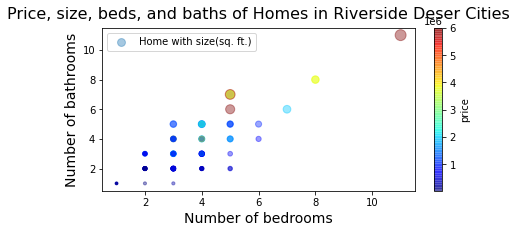

In [ ]:
fig, ax = plt.subplots(figsize = (7,3))

home_prices.plot(ax = ax, kind = 'scatter', x = 'bedrooms', y = 'bathrooms', 
 s = home_prices['floorSize']/100, label = 'Home with size(sq. ft.)',
 c = 'price', cmap = plt.get_cmap('jet'), vmax = 6000000,
 colorbar = True, alpha = 0.4).set_title('Price, size, beds, and baths of Homes in Riverside Deser Cities', 
 fontsize = 16, ha = 'center', va = 'bottom')

ax.set_xlabel('Number of bedrooms', fontsize = 14)
ax.set_ylabel('Number of bathrooms', fontsize = 14)
plt.show()

# Average Price per city


In [269]:
home_prices.head()

,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type
0,33.756014,-116.389203,1850.0,549900.0,Palm Desert,3.0,2.0,House for sale
1,33.754975,-116.388469,1850.0,549900.0,Palm Desert,3.0,2.0,House for sale
2,33.962587,-116.571054,1618.0,418300.0,Desert Hot Springs,3.0,3.0,House for sale
3,33.698457,-116.380851,2202.0,1200000.0,Palm Desert,3.0,2.0,House for sale
4,33.794000,-116.546483,2414.0,274000.0,Palm Springs,3.0,3.0,Condo for sale


In [246]:
avg_price = pd.DataFrame(home_prices.groupby('address')['price'].mean())
avg_price['price'] = avg_price['price'].astype('int64')
avg_price.reset_index(inplace=True)

In [275]:
avg_price

,address,price
0,Cathedral City,343443
1,Coachella,320000
2,Desert Hot Springs,350915
3,Espana Almeria,500190
4,Flair at Miralon,925000
5,Indian Wells,762158
6,Indio,917253
7,La Quinta,1265984
8,Palm Desert,975792
9,Palm Springs,913900


In [277]:
df_cities

,name,state,pop_2010,latitude,longitude,x,y
0,Bermuda Dunes,CA,7282.0,33.742799,-116.289175,-116.289187,33.742804
1,Mecca,CA,8577.0,33.571692,-116.077224,-116.077236,33.571697
2,Thousand Palms,CA,7715.0,33.820018,-116.390289,-116.390301,33.820023
3,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748
4,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305
5,Indian Wells,CA,4958.0,33.718633,-116.308343,-116.308354,33.718638
6,Indio,CA,76036.0,33.720577,-116.215562,-116.215574,33.720582
7,Desert Hot Springs,CA,25938.0,33.961124,-116.501678,-116.501690,33.961129
8,Palm Desert,CA,48445.0,33.722245,-116.374456,-116.374467,33.722249
9,Palm Springs,CA,44552.0,33.830296,-116.545292,-116.545304,33.830301


In [278]:
df_cities_merged = df_cities.merge(avg_price, left_on='name', right_on='address')
df_cities

,name,state,pop_2010,latitude,longitude,x,y
0,Bermuda Dunes,CA,7282.0,33.742799,-116.289175,-116.289187,33.742804
1,Mecca,CA,8577.0,33.571692,-116.077224,-116.077236,33.571697
2,Thousand Palms,CA,7715.0,33.820018,-116.390289,-116.390301,33.820023
3,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748
4,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305
5,Indian Wells,CA,4958.0,33.718633,-116.308343,-116.308354,33.718638
6,Indio,CA,76036.0,33.720577,-116.215562,-116.215574,33.720582
7,Desert Hot Springs,CA,25938.0,33.961124,-116.501678,-116.501690,33.961129
8,Palm Desert,CA,48445.0,33.722245,-116.374456,-116.374467,33.722249
9,Palm Springs,CA,44552.0,33.830296,-116.545292,-116.545304,33.830301


# Clustering

In [ ]:
home_onehot = pd.get_dummies(home_prices[['type']], prefix='', prefix_sep='')

home_onehot['NAME'] = home_prices['address']
fixed = [home_onehot.columns[-1]] + list(home_onehot.columns[:-1])
home_onehot = home_onehot[fixed]


In [268]:
df_cities.head()

,name,state,pop_2010,latitude,longitude,x,y
0,Bermuda Dunes,CA,7282.0,33.742799,-116.289175,-116.289187,33.742804
1,Mecca,CA,8577.0,33.571692,-116.077224,-116.077236,33.571697
2,Thousand Palms,CA,7715.0,33.820018,-116.390289,-116.390301,33.820023
3,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748
4,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305


In [258]:
home_grouped = home_onehot.groupby('NAME').mean().reset_index()
home_grouped

,NAME,Coming soon,Condo for sale,Home for sale,House for sale,Multi-family home for sale,New construction,Townhouse for sale
0,Cathedral City,0.062500,0.125000,0.437500,0.375000,0.000000,0.000000,0.000000
1,Coachella,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,Desert Hot Springs,0.000000,0.000000,0.181818,0.545455,0.045455,0.090909,0.000000
3,Espana Almeria,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,Flair at Miralon,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5,Indian Wells,0.000000,0.166667,0.000000,0.833333,0.000000,0.000000,0.000000
6,Indio,0.000000,0.111111,0.055556,0.722222,0.055556,0.055556,0.000000
7,La Quinta,0.000000,0.160000,0.000000,0.840000,0.000000,0.000000,0.000000
8,Palm Desert,0.038462,0.307692,0.115385,0.500000,0.000000,0.000000,0.000000
9,Palm Springs,0.000000,0.297297,0.108108,0.459459,0.027027,0.027027,0.054054


In [299]:
from sklearn.cluster import KMeans

klcusters = 5
home_grouped_clustering = home_grouped.drop('NAME',1)

kmeans = KMeans(n_clusters=klcusters, random_state=34).fit(home_grouped_clustering)
kmeans.labels_[0:10]

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



array([3, 0, 3, 1, 1, 2, 2, 2, 3, 3], dtype=int32)

In [296]:
home_grouped['Cluster Labels'] = kmeans.labels_
df_all_merged = df_cities_merged.merge(home_grouped, left_on='address', right_on='NAME')
df_all_merged.drop(['state','x','y','address','NAME','state'], 1, inplace=True)


/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [297]:
df_all_merged


,name,pop_2010,latitude,longitude,price,Coming soon,Condo for sale,Home for sale,House for sale,Multi-family home for sale,New construction,Townhouse for sale,Cluster Labels
0,Thousand Palms,7715.0,33.820018,-116.390289,395000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4
1,Cathedral City,51200.0,33.779743,-116.465291,343443,0.062500,0.125000,0.437500,0.375000,0.000000,0.000000,0.000000,0
2,Coachella,40704.0,33.680300,-116.173894,320000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4
3,Indian Wells,4958.0,33.718633,-116.308343,762158,0.000000,0.166667,0.000000,0.833333,0.000000,0.000000,0.000000,2
4,Indio,76036.0,33.720577,-116.215562,917253,0.000000,0.111111,0.055556,0.722222,0.055556,0.055556,0.000000,2
5,Desert Hot Springs,25938.0,33.961124,-116.501678,350915,0.000000,0.000000,0.181818,0.545455,0.045455,0.090909,0.000000,0
6,Palm Desert,48445.0,33.722245,-116.374456,975792,0.038462,0.307692,0.115385,0.500000,0.000000,0.000000,0.000000,0
7,Palm Springs,44552.0,33.830296,-116.545292,913900,0.000000,0.297297,0.108108,0.459459,0.027027,0.027027,0.054054,0
8,Rancho Mirage,17218.0,33.739744,-116.412790,1587000,0.000000,0.200000,0.000000,0.800000,0.000000,0.000000,0.000000,2
9,La Quinta,37467.0,33.663357,-116.310010,1265984,0.000000,0.160000,0.000000,0.840000,0.000000,0.000000,0.000000,2


In [322]:
# create cluster maps
home_clustered_map = folium.Map(location=[y_map,x_map], zoom_start=11, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(home_clustered_map)

# # color schemes for clusters
x =np.arange(klcusters)
ys = [i+x+(i*x)**3.2 for i in range(klcusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, city, cluster in zip(
                                  df_all_merged['latitude'], 
                                  df_all_merged['longitude'], 
                                  df_all_merged['name'], 
                                  df_all_merged['Cluster Labels']):
    label = ("Cluster : {}, Neighborhood: {}").format(cluster, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(home_clustered_map)
    

home_clustered_map

# Crime analysis

In [ ]:
# Add Crime Rate
df_crime['crime
 rate'] = df_crime['case_number']/df_crime['pop_2010']
df_crime.head()

,Unnamed: 0,name,state,pop_2010,latitude,longitude,x,y,agency_name,aggravated-assault,...,human-trafficing,larceny,motor-vehicle-theft,property-crime,rape,rape-legacy,robbery,violent-crime,case_number,crime rate
0,0,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748,Cathedral City Police Department,76.2,...,0.0,356.8,281.0,867.4,17.2,0.0,47.2,144.4,1884.2,27.173336
1,1,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305,Coachella Police Department,80.0,...,0.0,754.0,215.2,1143.6,5.8,0.0,47.4,134.4,2426.2,16.776853
2,2,Desert Hot Springs,CA,25938.0,33.961124,-116.501678,-116.501690,33.961129,Desert Hot Springs Police Department,185.4,...,0.0,223.2,233.0,827.6,16.6,0.0,55.2,262.6,1923.4,13.485494
3,3,Indian Wells,CA,4958.0,33.718633,-116.308343,-116.308354,33.718638,Indian Wells Police Department,4.4,...,0.0,91.0,8.0,137.8,0.4,0.0,0.8,5.6,281.2,17.631579
4,4,Indio,CA,76036.0,33.720577,-116.215562,-116.215574,33.720582,Indio Police Department,384.0,...,0.0,1283.0,407.6,2093.0,37.0,0.0,113.0,537.2,4729.2,16.077984


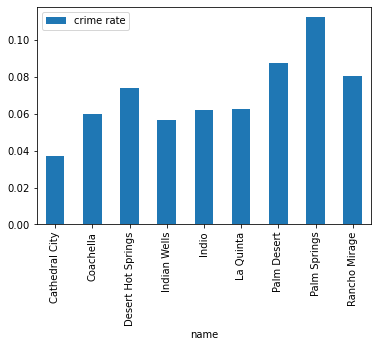

In [14]:

# Plot most crime-ridden city
ax = df_crime.plot.bar(x='name', y='crime rate')

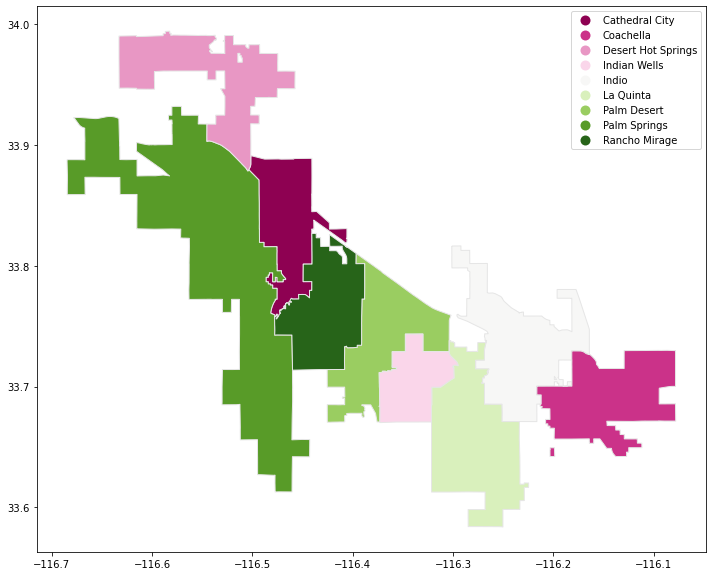

In [95]:
# Plot Cities on map
fp = '500Cities/tl_2020_06_place.shx'
map_df = gpd.read_file(fp)
cities = df_crime.name.unique()
map_of_cities = map_df[map_df['NAME'].isin(cities)].plot(label='NAME', column='NAME',figsize=(12,14), cmap='PiYG', linewidth=1, edgecolor='0.9', legend=True)

In [112]:
map_cit_df = map_df[['NAME','geometry']]

In [110]:
df_crime_small = df_crime[['name','crime rate','case_number']]
df_crime_small.rename(columns={'name':'NAME'}, inplace=True)
df_crime_small.head()

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,NAME,crime rate,case_number
0,Cathedral City,0.036801,1884.2
1,Coachella,0.059606,2426.2
2,Desert Hot Springs,0.074154,1923.4
3,Indian Wells,0.056716,281.2
4,Indio,0.062197,4729.2


In [113]:
df_crime_cit = map_cit_df.merge(df_crime_small, on='NAME')
df_crime_cit.head()

,NAME,geometry,crime rate,case_number
0,Indio,"POLYGON ((-116.30127 33.81647, -116.29218 33.8...",0.062197,4729.2
1,Cathedral City,"POLYGON ((-116.50327 33.88036, -116.50320 33.8...",0.036801,1884.2
2,Palm Desert,"POLYGON ((-116.42551 33.71414, -116.42198 33.7...",0.087666,4247.0
3,Coachella,"MULTIPOLYGON (((-116.20339 33.64793, -116.2033...",0.059606,2426.2
4,Indian Wells,"POLYGON ((-116.37355 33.68380, -116.37311 33.6...",0.056716,281.2


In [ ]:
# find the center points from the coordinates
x_map=df_crime_cit.centroid.x.mean()
y_map=df_crime_cit.centroid.y.mean()
print(x_map, y_map)

In [138]:
mymap = folium.Map(location=[y_map,x_map], zoom_start=11, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(mymap)


In [139]:
mymap.choropleth(
    geo_data=df_crime_cit,
    name='Choropleth',
    data=df_crime_cit,
    columns=['NAME','crime rate'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Crime Rate (per 100)',
 smooth_factor=0
)
mymap

/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



In [1]:
colormap = cm.linear.YlGnBu_09.to_step(data=df_crime_cit['crime rate'], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])
colormap

NameError: name 'cm' is not defined

In [141]:
style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties']['crime rate']), 
                            'fillOpacity':0.75}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    df_crime_cit,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','crime rate'],
        aliases=['City: ','Crime Rate in %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        sticky=True
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)
mymap